In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed

#  V_A change

In [2]:
base_V_A = 1
dt = 1e-4

def V_A_change(t, slope, base_V_A):
    return base_V_A + slope * t

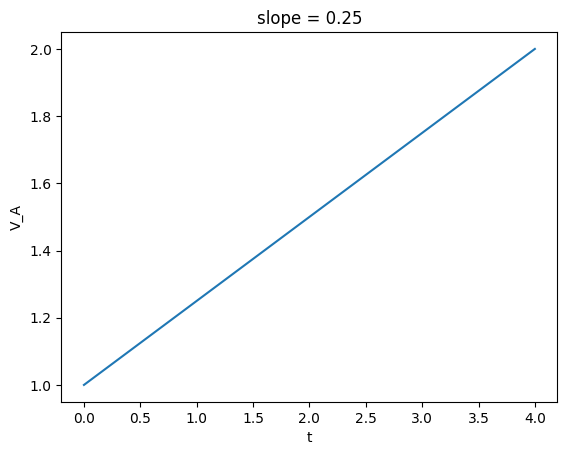

In [3]:
t_pts = np.arange(0, 4, dt)
slope = 0.25
V_A_pts = V_A_change(t_pts, slope, base_V_A)

plt.plot(t_pts, V_A_pts)
plt.title(f'slope = {slope}')
plt.xlabel('t')
plt.ylabel('V_A');

# get LED times

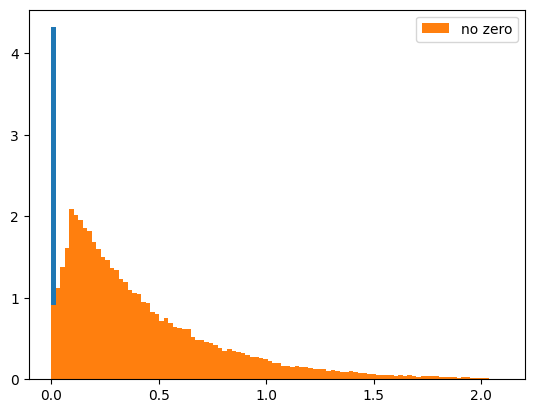

In [4]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

LED_times = (df['intended_fix'] - df['LED_onset_time']).values
plt.hist(LED_times, bins=100, density=True);

# remove zero from LED_times
LED_times = LED_times[LED_times != 0]
plt.hist(LED_times, bins=100, density=True, label='no zero');

plt.legend();


# simulator

In [5]:
dt = 1e-4; dB = 1e-2
LED_onset_time = 0.5

def proactive_V_A_change_simulate(base_V_A, theta_A, slope):
    DV = 0
    t = 0
    # LED_onset_time = np.random.choice(LED_times)
    # TEMP - LED_onset_time is hardcode
    while True:
        if t <= LED_onset_time:
            v = base_V_A
        else:
            v = base_V_A + slope * (t - LED_onset_time)
        
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= theta_A:
            return t, LED_onset_time, ( base_V_A, theta_A, slope )
        

# check simulated data

In [6]:
# ---- PARAMS  ---
base_V_A = 1
theta_A = 2
slope = 0.25

In [7]:

N_sim = int(25e3)
sim_results = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate)(base_V_A, theta_A, slope) for _ in range(N_sim))

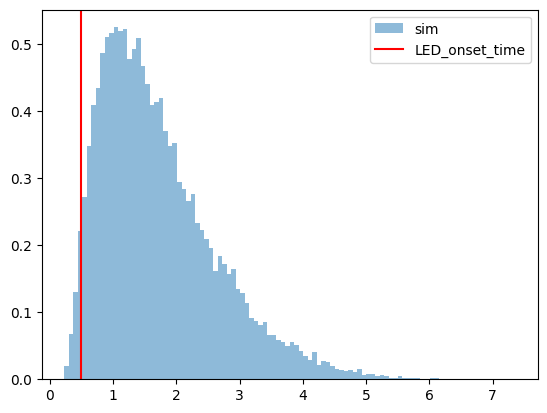

In [8]:
plt.hist([t for t, _, _ in sim_results], bins=100, density=True, alpha=0.5, label='sim')
plt.axvline(LED_onset_time, color='red', label='LED_onset_time')
plt.legend();

# SBI

In [11]:
import torch

from sbi.inference import SNLE

In [16]:
N = int(50e3)

# theta
base_V_A_distr = torch.distributions.Uniform(0.1, 3.0).sample((N,))
theta_A_distr = torch.distributions.Uniform(0.1, 3.0).sample((N,))
slope_distr = torch.distributions.Uniform(0.1, 1.0).sample((N,))

In [17]:
sim_results = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate)(base_V_A.item(), theta_A.item(), slope.item()) \
                                   for base_V_A, theta_A, slope in zip(base_V_A_distr, theta_A_distr, slope_distr))

In [25]:
rts = torch.tensor([t for t, _, _ in sim_results]).reshape(-1, 1)
params = torch.tensor([[param[0], param[1], param[2], LED_time] for _, LED_time, param in sim_results]).reshape(-1, 4)

print(rts.shape, params.shape)

torch.Size([50000, 1]) torch.Size([50000, 4])


In [ ]:
inference = SNLE(density_estimator='nsf')
likelihood_estimator = inference.append_simulations(params, rts).train()

 Training neural network. Epochs trained: 8